In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip3 install panns-inference

In [ ]:
# !wget -O "/content/drive/MyDrive/W210/Models/Cnn14_mAP=0.431.pth" "https://zenodo.org/record/3987831/files/Cnn14_mAP%3D0.431.pth?download=1"

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import librosa
import panns_inference
from panns_inference import AudioTagging
from panns_inference.models import Cnn14
class SpectrogramPANN(nn.Module):
    def __init__(self, pretrained_model, num_classes, freeze_backbone=False):
        super().__init__()

        self.cnn14 = pretrained_model

        # Remove audio extractors since we have already converted to spectrograms
        del self.cnn14.spectrogram_extractor
        del self.cnn14.logmel_extractor

        self.fc2 = nn.Linear(2048, num_classes)

        if freeze_backbone:
            for name, param in self.cnn14.named_parameters():
                if 'conv' in name:
                    param.requires_grad = False

    def forward(self, x):
        x = self.cnn14.conv_block1(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.cnn14.conv_block2(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.cnn14.conv_block3(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.cnn14.conv_block4(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.cnn14.conv_block5(x, pool_size=(2, 2), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = self.cnn14.conv_block6(x, pool_size=(1, 1), pool_type='avg')
        x = F.dropout(x, p=0.2, training=self.training)
        x = torch.mean(x, dim=3)

        (x1, _) = torch.max(x, dim=2)
        x2 = torch.mean(x, dim=2)
        x = x1 + x2

        x = F.dropout(x, p=0.5, training=self.training)
        x = F.relu_(self.cnn14.fc1(x))
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.fc2(x)

        return x


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import h5py
import pandas as pd
from sklearn.metrics import classification_report
import torchaudio.transforms as T
import random
import warnings

warnings.filterwarnings("ignore", message="Downcasting object dtype arrays on .fillna")

class SpectrogramDataset(Dataset):
    """
    Custom dataset for spectrogram data.

    When the Spectrogram dataset is used to create a dataloader object, the
    dataloader consists of batches of spectrograms and their corresponding labels.
    Here is info on the shape of the spectrogram and label objects in each batch:

    Spectrogram Tensor Dimensions in Batch - (32, 1, 128, 626)
        Batch Size: 32
        Channels: 1 - Think of it as a grayscale image, rather than RGB
        Mel Bands (Height): 128 - 128 Mel filter banks (typical for Mel spectrograms)
        Time Steps (Width): 626 - Number of frames

    Label Tensor Dimensions in Batch - (32, 13)
        Batch Size: 32
        Number of Labels: 13 - Multi-hot encoded vector of the 13 effects (includes clean). This
            would increase if we added additional effects.
    """

    def __init__(self, hdf5_file, csv_file, augment=True, noise_level=0.03,
                 pitch_shift_range=(-0.5, 0.5), time_shift_range=(-5, 5), volume_change_range=(-5, 5)):
        """
        Args:
            hdf5_file (str): Path to the HDF5 file containing spectrograms.
            csv_file (str): Path to CSV file with labels.
            augment (bool): Whether to apply data augmentation.
            noise_level (float): Standard deviation of Gaussian noise to add.
            pitch_shift_range (tuple): Min/max semitones for pitch shifting.
        """
        self.hdf5_file_path = hdf5_file
        self.labels = pd.read_csv(csv_file)
        self.labels = self.labels.iloc[:, [0] + list(range(-12, 0))]
        self.label_map = self.labels.columns[1:].tolist()  # Get effect label names
        self.hdf5_file = None  # Open HDF5 file once per worker

        self.augment = augment
        self.noise_level = noise_level
        self.pitch_shift_range = pitch_shift_range
        self.time_shift_range = time_shift_range
        self.volume_change_range = volume_change_range

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Open HDF5 file per worker to avoid threading issues
        if self.hdf5_file is None:
            self.hdf5_file = h5py.File(self.hdf5_file_path, "r", swmr=True)

        # Retrieve spectrogram
        key = self.labels.iloc[idx]['key']
        spectrogram = torch.tensor(self.hdf5_file[key][()], dtype=torch.float32).unsqueeze(0)

        # Retrieve labels
        label_values = self.labels.iloc[idx][1:].fillna(0).astype(float).values
        label = torch.tensor(label_values, dtype=torch.float32)

        # Data augmentation
        if self.augment:
            spectrogram = self.add_noise(spectrogram)
            spectrogram = self.pitch_shift(spectrogram)
            spectrogram = self.time_shift(spectrogram)
            spectrogram = self.volume_change(spectrogram)

        return spectrogram, label

    def add_noise(self, spectrogram):
        """Adds Gaussian noise where noise level is randomly chosen between 0 and self.noise_level."""
        if random.random() < 0.5:
            return spectrogram
        noise_level = random.uniform(0, self.noise_level)  # Random noise per sample
        noise = torch.randn_like(spectrogram) * noise_level  # Scale noise
        return spectrogram + noise

    def pitch_shift(self, spectrogram):
        """Shifts spectrogram frequency bins using torch.roll() with zero padding."""
        if random.random() < 0.5:
            return spectrogram
        semitone_shift = random.uniform(*self.pitch_shift_range)  # Random shift between min/max
        shift_bins = int(semitone_shift / 12 * spectrogram.shape[-2])  # Convert semitone shift to frequency bins

        # Apply frequency bin shift using torch.roll() with zero-padding
        shifted = torch.roll(spectrogram, shifts=shift_bins, dims=-2)  # Shift along frequency axis

        if shift_bins > 0:  # Shift up (higher pitch)
            shifted[..., :shift_bins, :] = 0  # Zero-pad low frequencies
        elif shift_bins < 0:  # Shift down (lower pitch)
            shifted[..., shift_bins:, :] = 0  # Zero-pad high frequencies

        return shifted

    def time_shift(self, spectrogram):
        """Shifts spectrogram time steps using torch.roll() with zero padding."""
        if random.random() < 0.5:
            return spectrogram
        shift_frames = random.randint(*self.time_shift_range)  # Random shift between min/max
        shifted = torch.roll(spectrogram, shifts=shift_frames, dims=-1)
        if shift_frames > 0:
            shifted[..., :shift_frames, :] = 0
        elif shift_frames < 0:
            shifted[..., shift_frames:, :] = 0
        return shifted

    def volume_change(self, spectrogram):
        if random.random() < 0.5:
            return spectrogram
        volume_change = random.uniform(*self.volume_change_range)
        spectrogram = spectrogram * (1 + volume_change / 100)
        return spectrogram

    def __del__(self):
        if self.hdf5_file is not None:
            self.hdf5_file.close()

In [ ]:
!mkdir -p /content/Dataset
!cp -r /content/drive/MyDrive/W210/Dataset/final_real.csv /content/Dataset/final_real.csv
!cp -r /content/drive/MyDrive/W210/Dataset/final_real.h5 /content/Dataset/final_real.h5
!cp -r /content/drive/MyDrive/W210/Dataset/final_test.csv /content/Dataset/final_test.csv
!cp -r /content/drive/MyDrive/W210/Dataset/final_test.h5 /content/Dataset/final_test.h5
!cp -r /content/drive/MyDrive/W210/Dataset/final_train.csv /content/Dataset/final_train.csv
!cp -r /content/drive/MyDrive/W210/Dataset/final_train.h5 /content/Dataset/final_train.h5
!cp -r /content/drive/MyDrive/W210/Dataset/final_validate.csv /content/Dataset/final_validate.csv
!cp -r /content/drive/MyDrive/W210/Dataset/final_validate.h5 /content/Dataset/final_validate.h5

In [ ]:
# Initialize dataset from HD5F and csv file

h5_train_path = '/content/Dataset/final_train.h5'
csv_train_path = '/content/Dataset/final_train.csv'

h5_val_path = '/content/Dataset/final_validate.h5'
csv_val_path = '/content/Dataset/final_validate.csv'

h5_test_path = '/content/Dataset/final_test.h5'
csv_test_path = '/content/Dataset/final_test.csv'

h5_real_path = '/content/Dataset/final_real.h5'
csv_real_path = '/content/Dataset/final_real.csv'

pretrained_model_load_path = "/content/drive/MyDrive/W210/Models/Cnn14_mAP=0.431.pth"
model_save_path = "/content/drive/MyDrive/W210/Models/last_PANN_model.mod"
model_load_path = "/content/drive/MyDrive/W210/Models/last_PANN_model.mod"

train_dataset = SpectrogramDataset(h5_train_path, csv_train_path)
val_dataset = SpectrogramDataset(h5_val_path, csv_val_path)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=12, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=6, pin_memory=True)

num_classes = len(train_dataset.label_map)

pretrained_cnn14 = Cnn14(sample_rate=32000, window_size=1024, hop_size=320,
                         mel_bins=128, fmin=50, fmax=14000, classes_num=num_classes)
checkpoint = torch.load(pretrained_model_load_path, map_location=device)
pretrained_cnn14.load_state_dict(checkpoint["model"])

model = SpectrogramPANN(pretrained_model=pretrained_cnn14, num_classes=num_classes)
model.to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.398)  # 0.0001 → 0.00001 over 5 epochs
#optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9, weight_decay=1e-4)

# Training loop
num_epochs = 5
print_freq = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (spectrograms, labels) in enumerate(train_loader):
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        if (batch_idx + 1) % print_freq == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}")

    # Update learning rate
    scheduler.step()
    print(f"Updated Learning Rate: {scheduler.get_last_lr()}")

    # Validation step
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for spectrograms, labels in val_loader:
            spectrograms, labels = spectrograms.to(device), labels.to(device)
            outputs = model(spectrograms)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            # Compute accuracy
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Convert logits to binary predictions

            # Store for metric computation
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)

    # Convert lists to numpy arrays for metric calculations
    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    # Compute metrics
    accuracy = accuracy_score(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="macro", zero_division=0)
    recall = recall_score(all_labels, all_preds, average="macro", zero_division=0)
    f1 = f1_score(all_labels, all_preds, average="macro", zero_division=0)

    # Print classification report
    class_names = train_dataset.label_map
    print(classification_report(all_labels, all_preds, target_names=class_names))

    print(f"\nValidation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}\n")

    torch.save(model.state_dict(), model_save_path)
    print(f"Model saved to {model_save_path}")

<ipython-input-8-dbae858160a7>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_model_load_path, map_location=device)


Epoch [1/5], Batch [10/4062], Loss: 0.4595
Epoch [1/5], Batch [20/4062], Loss: 0.4212
Epoch [1/5], Batch [30/4062], Loss: 0.4130
Epoch [1/5], Batch [40/4062], Loss: 0.3331
Epoch [1/5], Batch [50/4062], Loss: 0.2069
Epoch [1/5], Batch [60/4062], Loss: 0.1943
Epoch [1/5], Batch [70/4062], Loss: 0.1455
Epoch [1/5], Batch [80/4062], Loss: 0.1703
Epoch [1/5], Batch [90/4062], Loss: 0.2186
Epoch [1/5], Batch [100/4062], Loss: 0.1228
Epoch [1/5], Batch [110/4062], Loss: 0.1789
Epoch [1/5], Batch [120/4062], Loss: 0.1559
Epoch [1/5], Batch [130/4062], Loss: 0.1122
Epoch [1/5], Batch [140/4062], Loss: 0.0996
Epoch [1/5], Batch [150/4062], Loss: 0.1603
Epoch [1/5], Batch [160/4062], Loss: 0.1020
Epoch [1/5], Batch [170/4062], Loss: 0.1317
Epoch [1/5], Batch [180/4062], Loss: 0.0863
Epoch [1/5], Batch [190/4062], Loss: 0.0950
Epoch [1/5], Batch [200/4062], Loss: 0.1080
Epoch [1/5], Batch [210/4062], Loss: 0.0835
Epoch [1/5], Batch [220/4062], Loss: 0.0804
Epoch [1/5], Batch [230/4062], Loss: 0.12

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   overdrive       1.00      0.98      0.99      3012
  distortion       0.99      1.00      1.00      4518
        fuzz       0.99      1.00      0.99      5271
     tremolo       0.99      1.00      1.00      3765
      phaser       1.00      0.99      0.99      4518
     flanger       0.94      1.00      0.97      3012
      chorus       0.99      1.00      1.00      5271
       delay       0.98      0.97      0.97      6777
 hall_reverb       0.93      0.98      0.96      4518
plate_reverb       0.97      0.92      0.94      3012
     octaver       0.98      1.00      0.99      2259
 auto_filter       0.89      1.00      0.94      3765

   micro avg       0.97      0.99      0.98     49698
   macro avg       0.97      0.99      0.98     49698
weighted avg       0.97      0.99      0.98     49698
 samples avg       0.95      0.96      0.95     49698


Validation Loss: 0.0220, Accuracy: 0.9384, Precision: 0.9718, Recall: 0.9855, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   overdrive       0.99      1.00      0.99      3012
  distortion       1.00      1.00      1.00      4518
        fuzz       1.00      1.00      1.00      5271
     tremolo       1.00      1.00      1.00      3765
      phaser       1.00      1.00      1.00      4518
     flanger       1.00      1.00      1.00      3012
      chorus       1.00      1.00      1.00      5271
       delay       0.98      0.98      0.98      6777
 hall_reverb       0.95      0.99      0.97      4518
plate_reverb       0.99      0.97      0.98      3012
     octaver       1.00      1.00      1.00      2259
 auto_filter       1.00      1.00      1.00      3765

   micro avg       0.99      0.99      0.99     49698
   macro avg       0.99      0.99      0.99     49698
weighted avg       0.99      0.99      0.99     49698
 samples avg       0.96      0.97      0.96     49698


Validation Loss: 0.0056, Accuracy: 0.9803, Precision: 0.9913, Recall: 0.9945, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   overdrive       1.00      1.00      1.00      3012
  distortion       1.00      1.00      1.00      4518
        fuzz       1.00      1.00      1.00      5271
     tremolo       1.00      1.00      1.00      3765
      phaser       1.00      1.00      1.00      4518
     flanger       1.00      1.00      1.00      3012
      chorus       1.00      1.00      1.00      5271
       delay       0.99      0.98      0.99      6777
 hall_reverb       0.98      0.98      0.98      4518
plate_reverb       0.99      0.99      0.99      3012
     octaver       1.00      1.00      1.00      2259
 auto_filter       1.00      1.00      1.00      3765

   micro avg       1.00      0.99      1.00     49698
   macro avg       1.00      1.00      1.00     49698
weighted avg       1.00      0.99      1.00     49698
 samples avg       0.97      0.97      0.97     49698


Validation Loss: 0.0035, Accuracy: 0.9863, Precision: 0.9971, Recall: 0.9952, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   overdrive       1.00      1.00      1.00      3012
  distortion       1.00      1.00      1.00      4518
        fuzz       1.00      1.00      1.00      5271
     tremolo       1.00      1.00      1.00      3765
      phaser       1.00      1.00      1.00      4518
     flanger       1.00      1.00      1.00      3012
      chorus       1.00      1.00      1.00      5271
       delay       1.00      0.98      0.99      6777
 hall_reverb       0.99      0.98      0.98      4518
plate_reverb       1.00      0.98      0.99      3012
     octaver       1.00      1.00      1.00      2259
 auto_filter       1.00      1.00      1.00      3765

   micro avg       1.00      0.99      1.00     49698
   macro avg       1.00      0.99      1.00     49698
weighted avg       1.00      0.99      1.00     49698
 samples avg       0.97      0.97      0.97     49698


Validation Loss: 0.0040, Accuracy: 0.9870, Precision: 0.9979, Recall: 0.9948, 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

   overdrive       1.00      1.00      1.00      3012
  distortion       1.00      1.00      1.00      4518
        fuzz       1.00      1.00      1.00      5271
     tremolo       1.00      1.00      1.00      3765
      phaser       1.00      1.00      1.00      4518
     flanger       1.00      1.00      1.00      3012
      chorus       1.00      1.00      1.00      5271
       delay       1.00      0.98      0.99      6777
 hall_reverb       0.99      0.99      0.99      4518
plate_reverb       0.99      1.00      0.99      3012
     octaver       1.00      1.00      1.00      2259
 auto_filter       1.00      1.00      1.00      3765

   micro avg       1.00      1.00      1.00     49698
   macro avg       1.00      1.00      1.00     49698
weighted avg       1.00      1.00      1.00     49698
 samples avg       0.97      0.97      0.97     49698


Validation Loss: 0.0032, Accuracy: 0.9892, Precision: 0.9976, Recall: 0.9966, 

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

test_dataset = SpectrogramDataset(h5_test_path, csv_test_path)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)

num_classes = len(test_dataset.label_map)

# Load a saved model for test dataset metrics
pretrained_cnn14 = Cnn14(sample_rate=32000, window_size=1024, hop_size=320,
                         mel_bins=64, fmin=50, fmax=14000, classes_num=527)

model = SpectrogramPANN(pretrained_model=pretrained_cnn14, num_classes=num_classes)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.to(device)
model.eval()
print("Model loaded successfully.")

print("\nEvaluating with external test dataset...")

model.eval()
criterion = nn.BCEWithLogitsLoss()
test_loss = 0.0
test_preds, test_labels = [], []

with torch.no_grad():
    for spectrograms, labels in test_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        test_loss += loss.item()

        # Convert logits to binary predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        test_preds.extend(predicted.cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

test_loss /= len(test_loader)

# Compute test metrics
test_preds = np.array(test_preds)
test_labels = np.array(test_labels)
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds, average="macro", zero_division=0)
test_recall = recall_score(test_labels, test_preds, average="macro", zero_division=0)
test_f1 = f1_score(test_labels, test_preds, average="macro", zero_division=0)

print(f"\nTest Loss: {test_loss:.4f}, Accuracy: {test_accuracy:.4f}, Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1-score: {test_f1:.4f}\n")

# Print classification report
class_names = test_dataset.label_map
print(classification_report(test_labels, test_preds, target_names=class_names))

<ipython-input-9-0439bd9ab0d1>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_model_load_path, map_location=device)
<ipython-input-9-04

Model loaded successfully.

Evaluating with external test dataset...

Test Loss: 0.0040, Accuracy: 0.9888, Precision: 0.9963, Recall: 0.9948, F1-score: 0.9955

              precision    recall  f1-score   support

   overdrive       1.00      0.99      1.00      3028
  distortion       1.00      1.00      1.00      4544
        fuzz       1.00      1.00      1.00      5300
     tremolo       1.00      1.00      1.00      3028
      phaser       1.00      1.00      1.00      4542
     flanger       1.00      1.00      1.00      3028
      chorus       1.00      1.00      1.00      5300
       delay       1.00      0.99      1.00      6814
 hall_reverb       0.98      0.99      0.98      3788
plate_reverb       0.99      1.00      1.00      3028
     octaver       0.99      0.99      0.99      2271
 auto_filter       1.00      0.99      0.99      3785

   micro avg       1.00      0.99      1.00     48456
   macro avg       1.00      0.99      1.00     48456
weighted avg       1.00     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

real_dataset = SpectrogramDataset(h5_real_path, csv_real_path)
real_loader = DataLoader(real_dataset, batch_size=32, shuffle=False, num_workers=12, pin_memory=True)

num_classes = len(real_dataset.label_map)

# Load a saved model for real dataset metrics
pretrained_cnn14 = Cnn14(sample_rate=32000, window_size=1024, hop_size=320,
                         mel_bins=64, fmin=50, fmax=14000, classes_num=527)

model = SpectrogramPANN(pretrained_model=pretrained_cnn14, num_classes=num_classes)
model.load_state_dict(torch.load(model_load_path, map_location=device))
model.to(device)
model.eval()
print("Model loaded successfully.")

print("\nEvaluating with external real dataset...")

model.eval()
criterion = nn.BCEWithLogitsLoss()
real_loss = 0.0
real_preds, real_labels = [], []

with torch.no_grad():
    for spectrograms, labels in real_loader:
        spectrograms, labels = spectrograms.to(device), labels.to(device)
        outputs = model(spectrograms)
        loss = criterion(outputs, labels)
        real_loss += loss.item()

        # Convert logits to binary predictions
        predicted = (torch.sigmoid(outputs) > 0.5).float()

        real_preds.extend(predicted.cpu().numpy())
        real_labels.extend(labels.cpu().numpy())

real_loss /= len(real_loader)

# Compute real metrics
real_preds = np.array(real_preds)
real_labels = np.array(real_labels)
real_accuracy = accuracy_score(real_labels, real_preds)
real_precision = precision_score(real_labels, real_preds, average="macro", zero_division=0)
real_recall = recall_score(real_labels, real_preds, average="macro", zero_division=0)
real_f1 = f1_score(real_labels, real_preds, average="macro", zero_division=0)

print(f"\nreal Loss: {real_loss:.4f}, Accuracy: {real_accuracy:.4f}, Precision: {real_precision:.4f}, Recall: {real_recall:.4f}, F1-score: {real_f1:.4f}\n")

# Print classification report
class_names = real_dataset.label_map
print(classification_report(real_labels, real_preds, target_names=class_names))

<ipython-input-10-f13ee5b3dd40>:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(pretrained_model_load_path, map_location=device)
<ipython-input-10-

Model loaded successfully.

Evaluating with external real dataset...

real Loss: 0.0897, Accuracy: 0.8730, Precision: 0.9233, Recall: 0.9607, F1-score: 0.9377

              precision    recall  f1-score   support

   overdrive       0.91      0.88      0.89      3432
  distortion       0.98      0.98      0.98      5148
        fuzz       0.99      0.99      0.99      6006
     tremolo       0.89      1.00      0.94      4290
      phaser       1.00      0.96      0.98      5148
     flanger       0.99      0.86      0.92      3432
      chorus       0.94      0.96      0.95      6006
       delay       0.99      0.96      0.98      7722
 hall_reverb       0.96      0.99      0.97      5148
plate_reverb       0.98      0.96      0.97      3432
     octaver       0.67      1.00      0.80      2574
 auto_filter       0.79      0.99      0.88      4290

   micro avg       0.93      0.96      0.95     56628
   macro avg       0.92      0.96      0.94     56628
weighted avg       0.94     

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


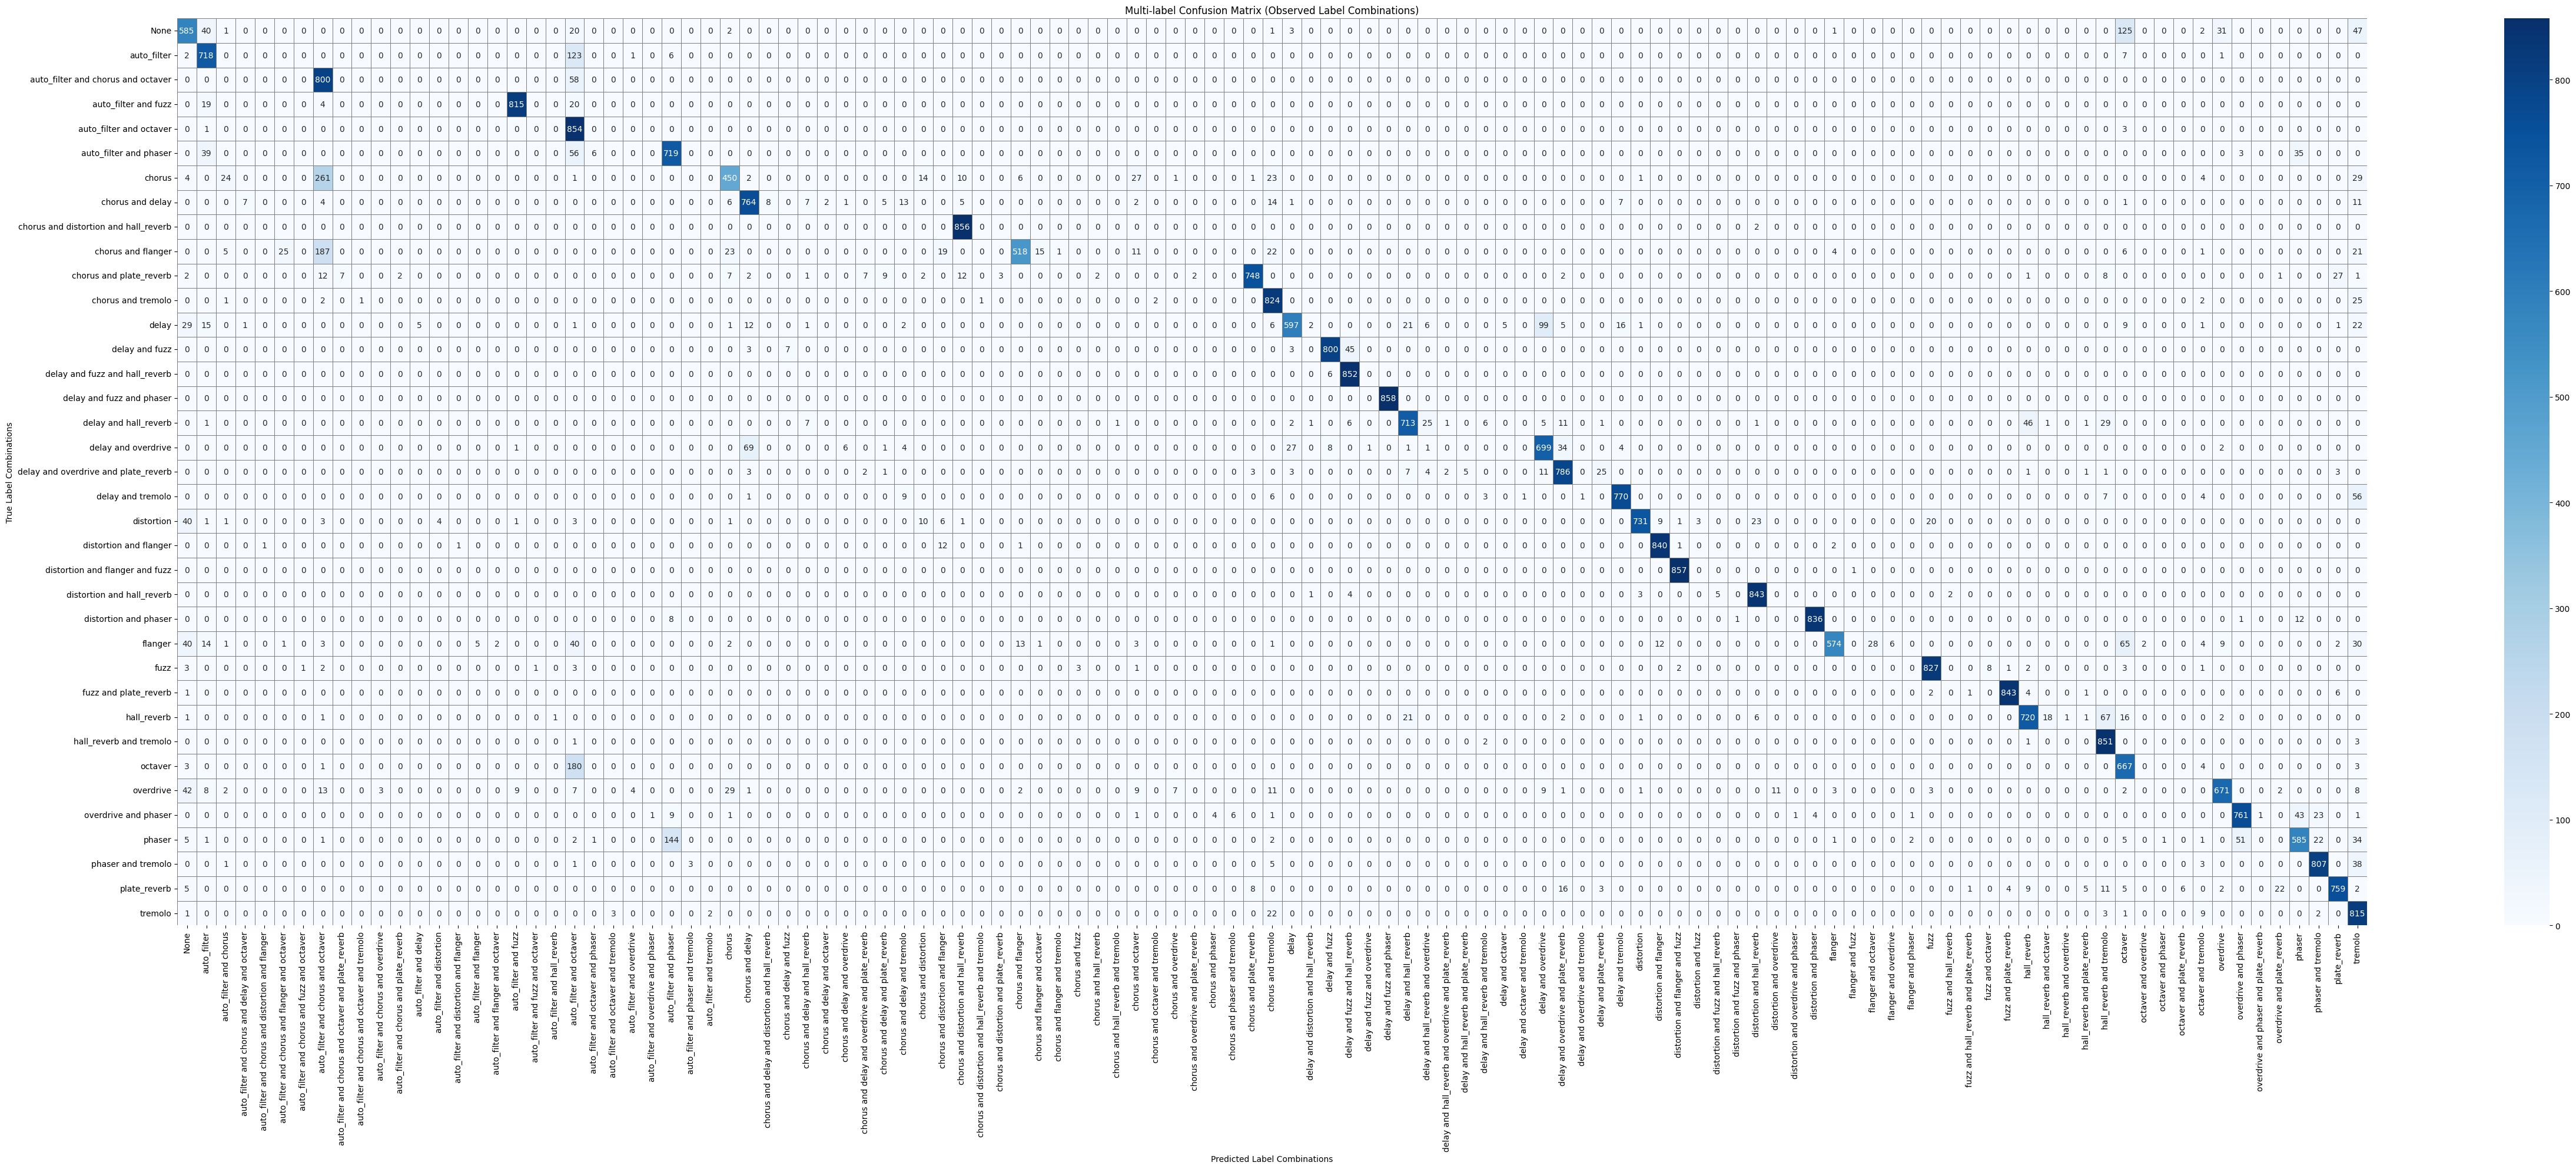

In [ ]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

def format_label_combination(combination):
    if len(combination) == 0:
        return "Clean"
    elif len(combination) == 1:
        return combination[0]
    else:
        return " and ".join(combination)

def create_multilabel_confusion_matrix(y_true, y_pred, class_names):
    combinations = defaultdict(lambda: defaultdict(int))
    for true_labels, pred_labels in zip(y_true, y_pred):
        true_label_names = tuple(sorted([class_names[i] for i in np.where(true_labels == 1)[0]]))
        pred_label_names = tuple(sorted([class_names[i] for i in np.where(pred_labels == 1)[0]]))
        true_label_names = format_label_combination(true_label_names)
        pred_label_names = format_label_combination(pred_label_names)

        combinations[true_label_names][pred_label_names] += 1
    df = pd.DataFrame.from_dict(combinations, orient='index').fillna(0)
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.reindex(sorted(df.index), axis=0)
    return df

multi_label_cm = create_multilabel_confusion_matrix(real_labels, real_preds, class_names)

plt.figure(figsize=(60, 20))
sns.heatmap(multi_label_cm, annot=True, fmt=".0f", cmap="Blues", linewidths=0.5, linecolor="gray")
plt.xlabel("Predicted Label Combinations")
plt.ylabel("True Label Combinations")
plt.title("Multi-label Confusion Matrix (Observed Label Combinations)")
plt.show()

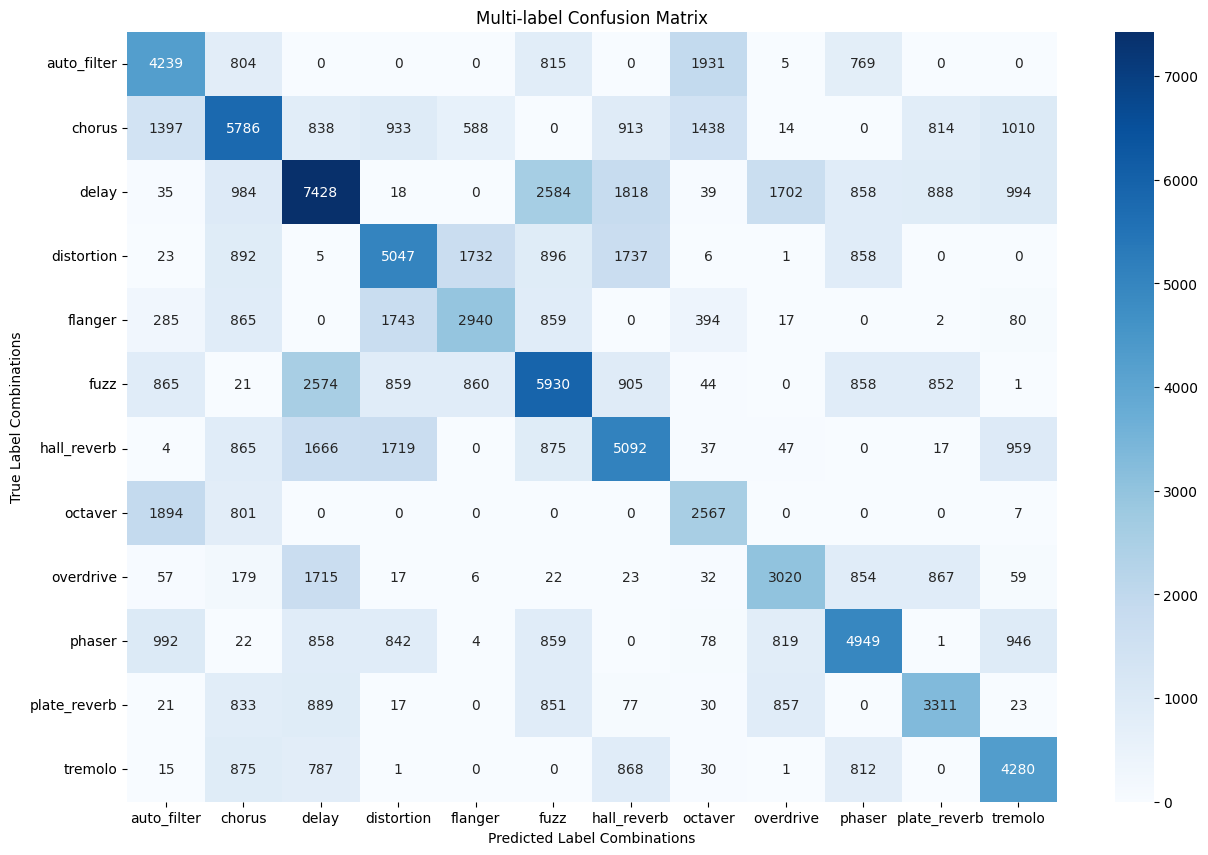

In [ ]:
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import combinations
from collections import defaultdict

def create_multilabel_confusion_matrix(y_true, y_pred, class_names):
    combinations = defaultdict(lambda: defaultdict(int))
    for true_labels, pred_labels in zip(y_true, y_pred):
        if true_labels
        for x, true_label in enumerate(true_labels):
            for y, pred_label in enumerate(pred_labels):
                if true_label == 1 and pred_label == 1:
                    true_label_name = class_names[x]
                    pred_label_name = class_names[y]
                    combinations[true_label_name][pred_label_name] += 1
    df = pd.DataFrame.from_dict(combinations, orient='index').fillna(0)
    df = df.reindex(sorted(df.columns), axis=1)
    df = df.reindex(sorted(df.index), axis=0)
    return df

multi_label_cm = create_multilabel_confusion_matrix(real_labels, real_preds, class_names)

plt.figure(figsize=(15, 10))
sns.heatmap(multi_label_cm, annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Label Combinations")
plt.ylabel("True Label Combinations")
plt.title("Multi-label Confusion Matrix")
plt.show()

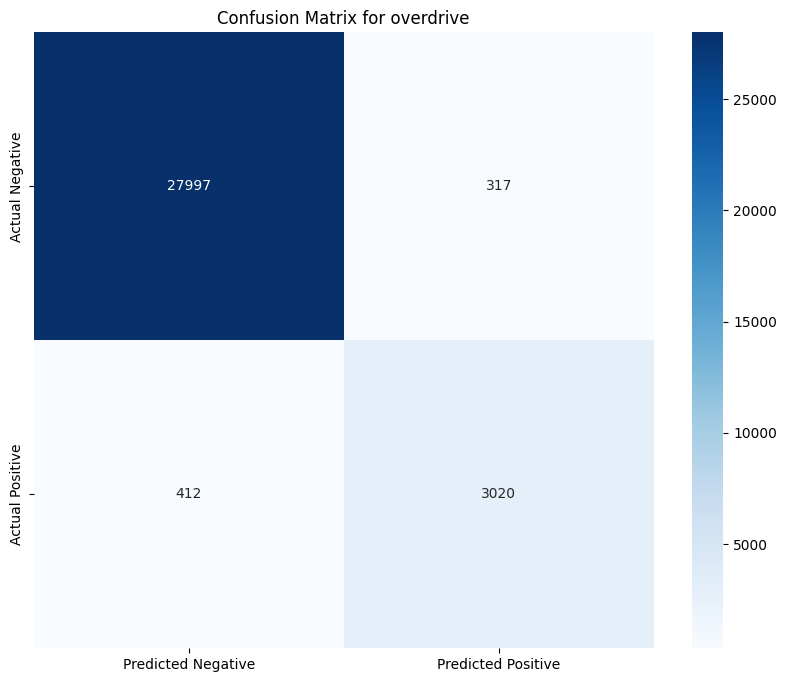

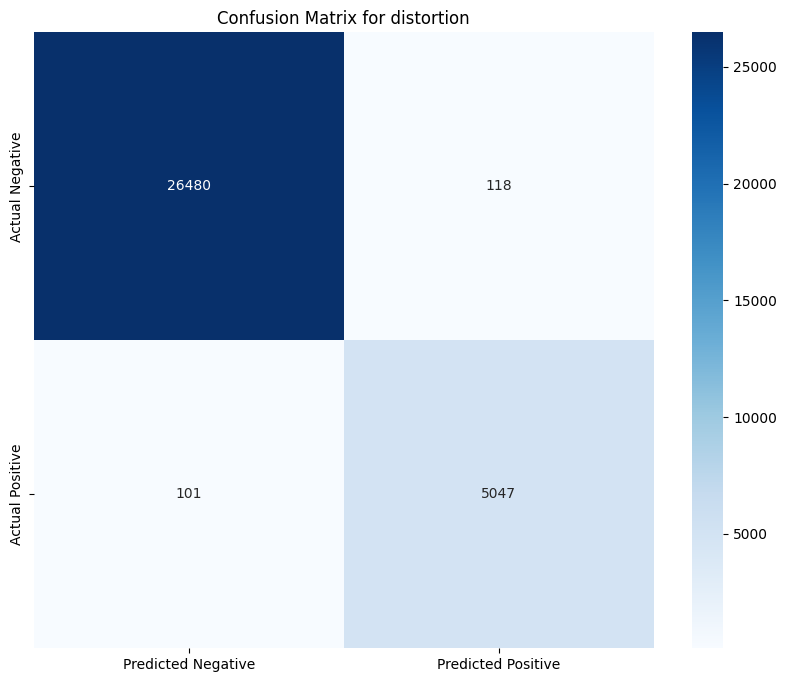

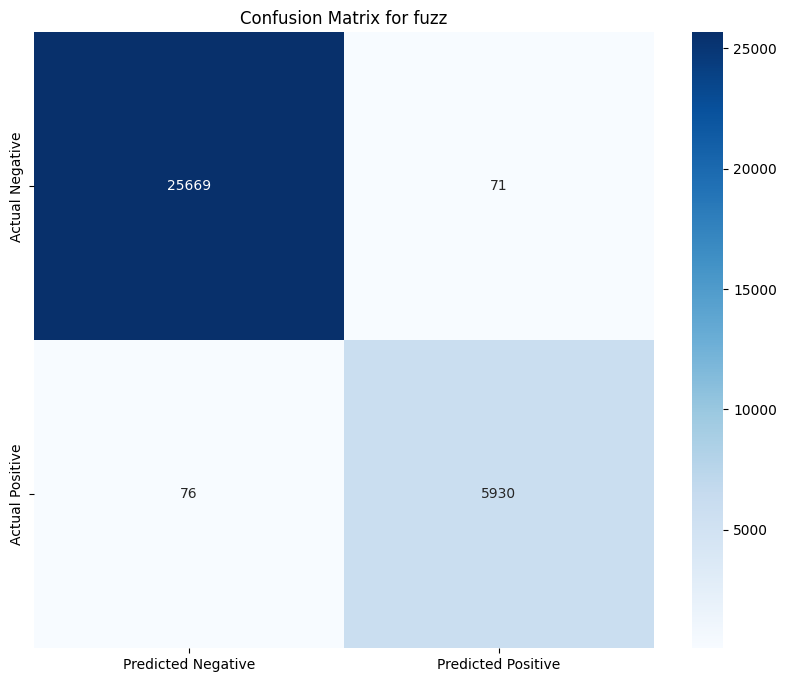

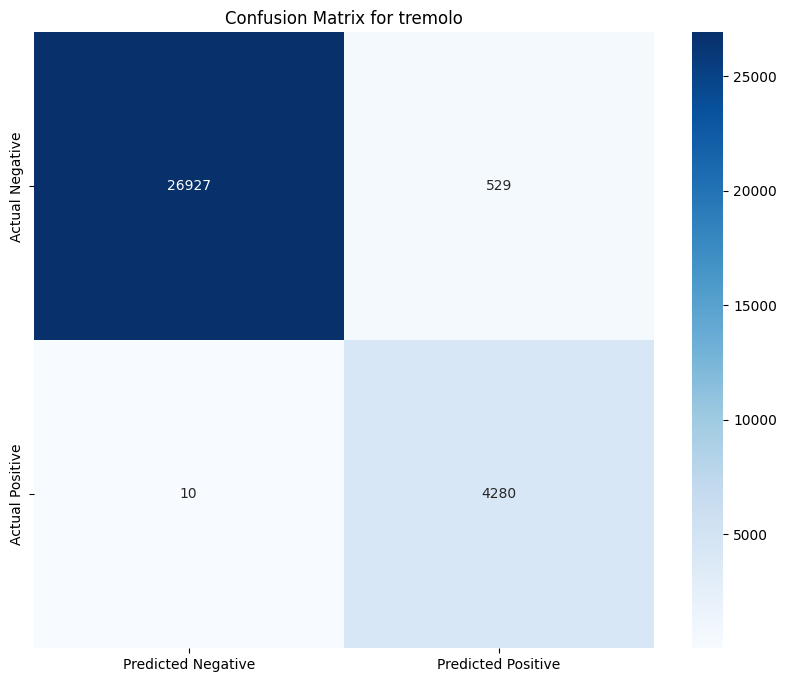

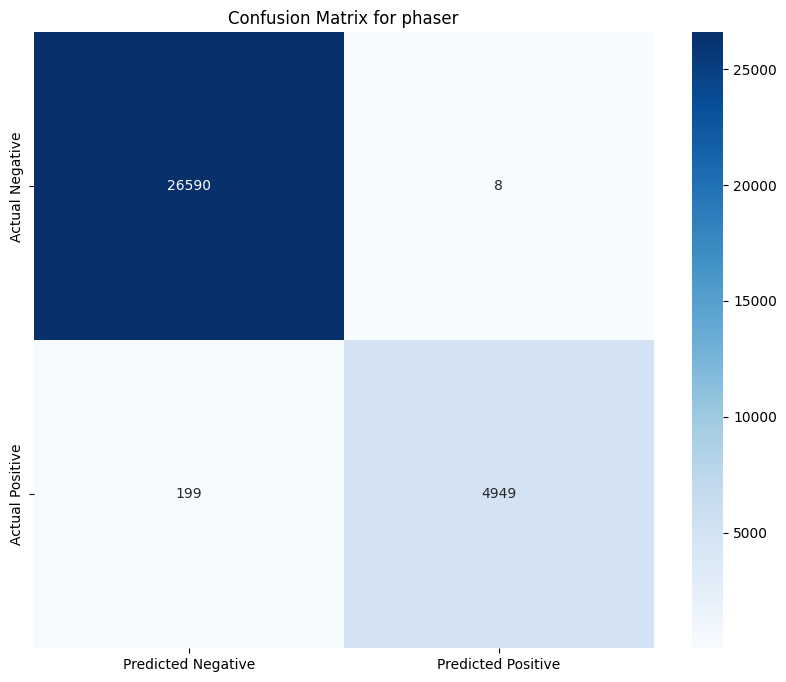

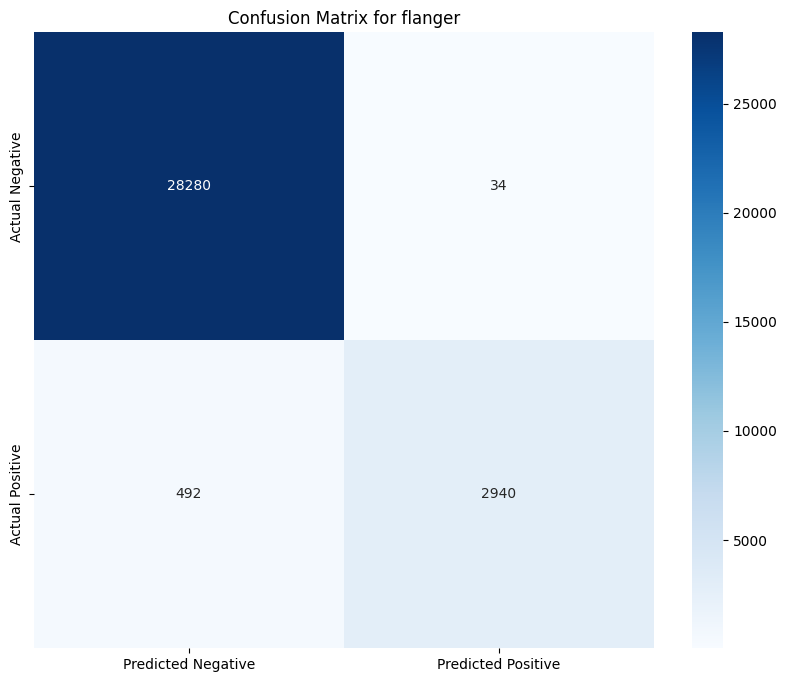

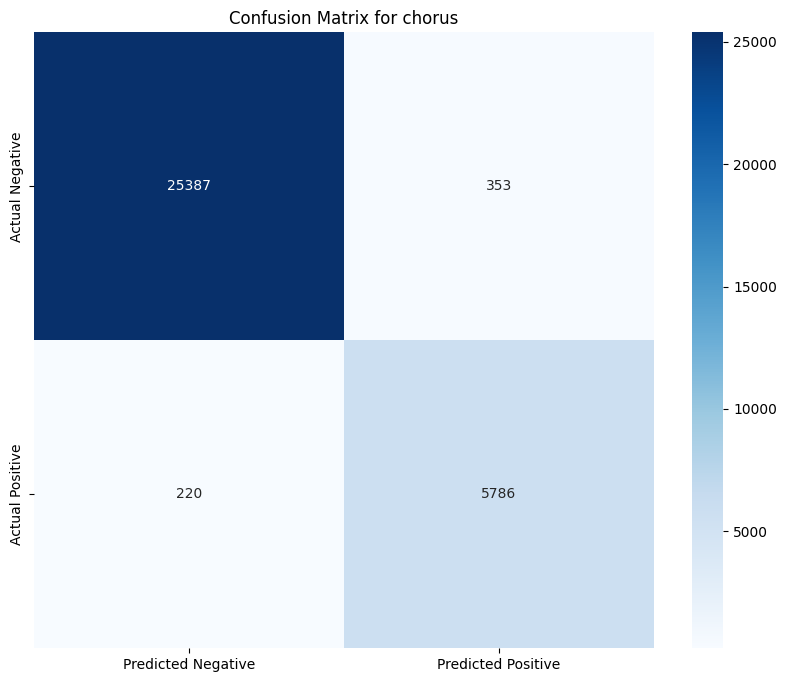

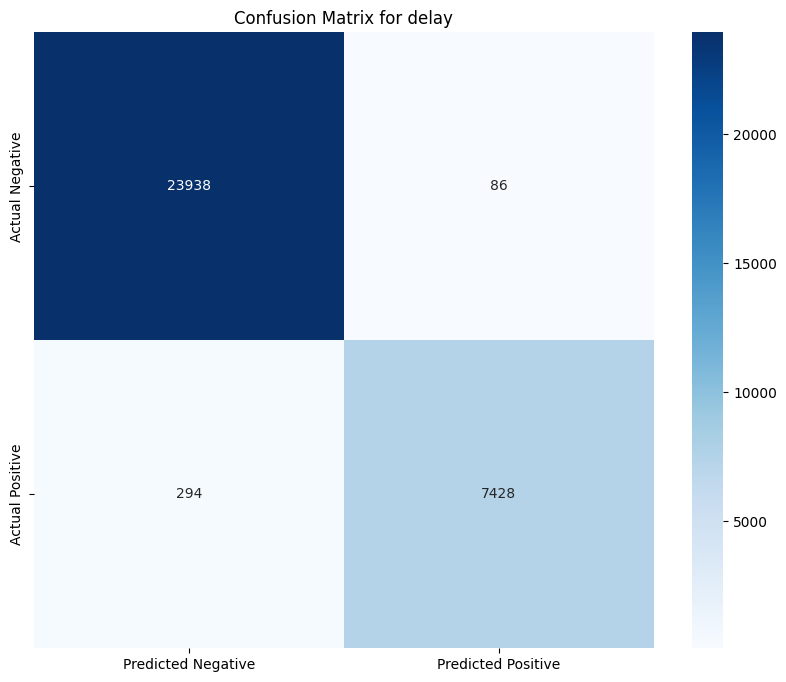

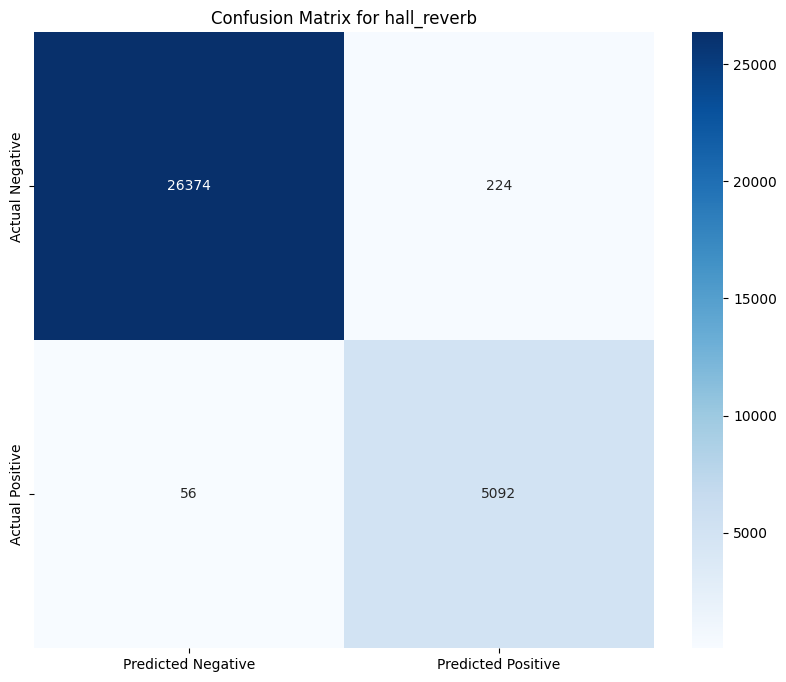

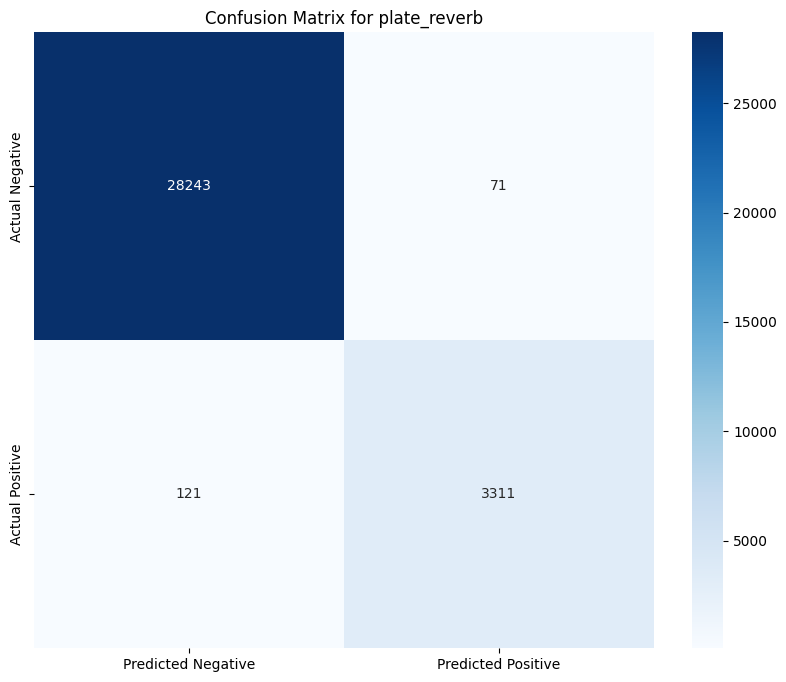

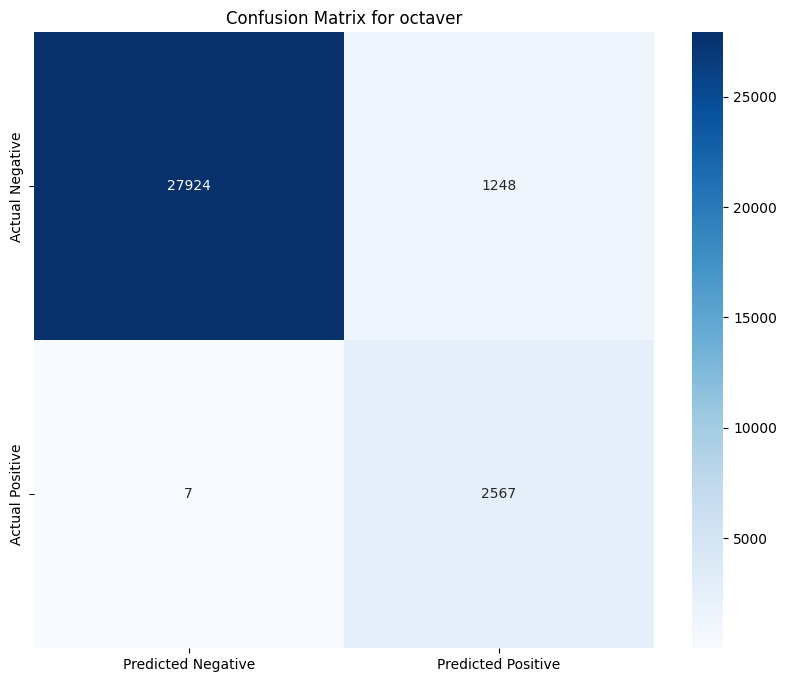

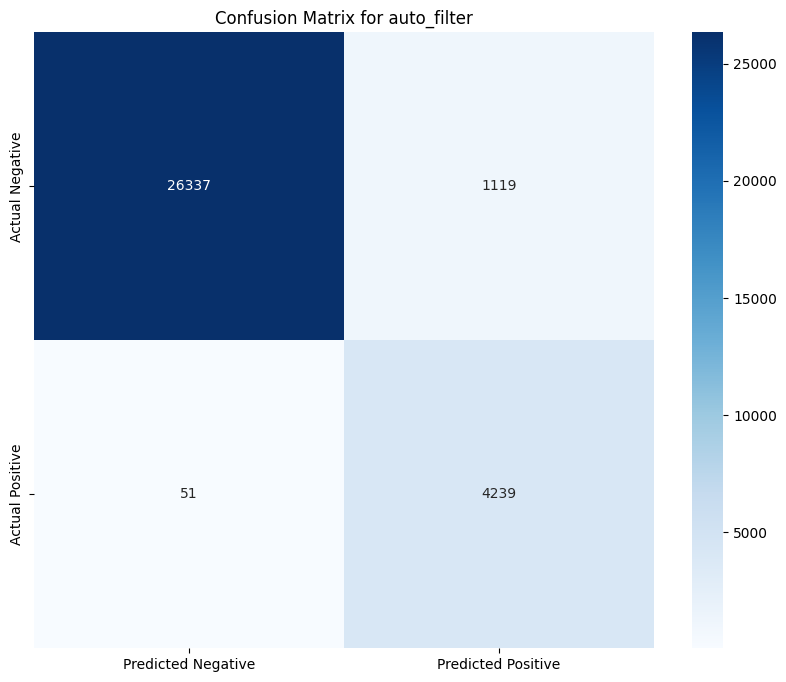

In [ ]:
confusion_matrix = multilabel_confusion_matrix(real_labels, real_preds, labels=[i for i in range(len(class_names))])

for i, cm in enumerate(confusion_matrix):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt=".0f", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"], yticklabels=["Actual Negative", "Actual Positive"])
    plt.title(f"Confusion Matrix for {class_names[i]}")
    plt.show()
